In [1]:
import re
import os
import datetime as dt
import logging
from urllib import request
from urllib.error import HTTPError, URLError

import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
from matplotlib import pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns

import boto3
from botocore.exceptions import ClientError
%matplotlib inline

In [2]:
states = '''Alabama
Alaska
Arizona
Arkansas
California
Colorado
Connecticut
Delaware
Florida
Georgia
Hawaii
Idaho
Illinois
Indiana
Iowa
Kansas
Kentucky
Louisiana
Maine
Maryland
Massachusetts
Michigan
Minnesota
Mississippi
Missouri
Montana
Nebraska
Nevada
New Hampshire
New Jersey
New Mexico
New York
North Carolina
North Dakota
Ohio
Oklahoma
Oregon
Pennsylvania
Rhode Island
South Carolina
South Dakota
Tennessee
Texas
Utah
Vermont
Virginia
Washington
West Virginia
Wisconsin
Wyoming'''.split('\n')

In [3]:
def get_folder_name():
    TODAY = dt.datetime.today().strftime('%Y-%m-%d')
    path_for_charts = 'Charts/' + TODAY + '/'
    if not os.path.exists(path_for_charts):
        os.makedirs(path_for_charts)
    return path_for_charts, TODAY

In [67]:
def state_plots(state, df, close = True, save = True):
    # Return path and today's date as string
    path_for_charts, TODAY = get_folder_name()
    
    # % Daily Positive
    _plot = df[['Percent Positive','7 Day Rolling Percent Pos']].\
        plot(style=['H','-'],
             color=['xkcd:dark blue','xkcd:sky blue'],
             figsize=(15,5),
             title=f'{state} Percent Positive')
    _plot.axhline(0, color='gray', linestyle='--', alpha=0.8)
    _plot.fill_between(df.index,0,5, color='green', alpha=0.3)
    _plot.text(pd.Timestamp('2020-03-09'),1,'Under 5%')
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Tests Percent Positive {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Daily Positive
    _plot = df[['Daily Positive','7 Day Rolling','14 Day Rolling']].\
        plot(style=['H','-.',':'],
             color=['xkcd:metallic blue','xkcd:warm pink','xkcd:dark purple'],
             figsize=(15,7),
             title=f'{state} Daily Positive')
    _plot.axhline(0, color='gray', linestyle='--', alpha=0.8)
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Cases Positive {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Total Cases and Tests
    _plot = df[['Cases','New Tests']].plot(
        style=['-','^'],
        color=['blue','green'],
        figsize=(10,5),
        title=f'Total {state} Cases and Total Tests (Swab/Saliva +)')
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Total Cases and Total Tests {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Daily Change Ratio
    _plot = df[['Growth Factor']].plot(
        color='xkcd:navy blue',
        figsize=(10,5),
        title=f'{state} Growth Factor')
    _plot.axhline(1, color='orange', linestyle='-.', alpha=0.8)
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Growth Factor {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
    
    # Velocity/Acceleration
    _plot = df[['Velocity of Daily Cases', 'Acceleration of Daily Cases']].\
        rolling(window=14, min_periods=7).mean()[::-1].\
        plot(figsize=(15,7),
            title = f'{state} Velocity and Accleration of Daily Cases {TODAY}',
            style=['-',':'],
            linewidth = 3,
            kind='line',
            color = ['xkcd:orange red', 'xkcd:rose pink'],
            alpha = 0.8
            ).axhline(0,
                      color='gray',
                      linestyle='--',
                      alpha=0.8)
    
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Velocity and Accleration of Daily Cases {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())
        
    _plot = df['Doubling Time'].plot(figsize=(15,7),
        title = f'{state} Cases Doubling Time {TODAY}',
        style=['-'],
        linewidth = 2,
        kind='line',
        color = ['xkcd:orange red'],
        alpha = 0.8
        ).set_ylabel('Days')
    if save:
        _plot.figure.savefig(
                  path_for_charts +\
                  f'{state} Cases Doubling Time {TODAY}.png',
                  dpi = 300,
                  facecolor = 'white')
    if close:
        plt.close(_plot.get_figure())

In [69]:
def get_state_data(state):
    """Takes string state as input and returns a processed dataframe. The data is called from covidtracking.com
        and returns the 'New Tests', 'Cases', 'Negative', 'Hospitalized', 'Deaths', 'Total',
       'Daily Positive', 'Percent Positive', 'Daily Hospitalized',
       'Daily Deaths', '7 Day Rolling', '14 Day Rolling',
       '7 Day Rolling Percent Pos', 'Doubling Time', 'State'"""
    # format state name for covidtracking.com
    state = state.lower().replace(' ', '-')
    # read historical data table from covidtracking.com and invert the order
    # data is presented most recent to oldest
    df = pd.read_html(f'https://covidtracking.com/data/state/{state}#historical')[1][::-1]
    # drop irrelevant columns
    df.drop(['Screenshots (ET)', 'Pending'], axis=1, inplace = True)
    
    # format columns and create features 
    df.Date = pd.to_datetime(df.Date)
    df.set_index('Date', inplace=True)
    df.Cases = df.Cases.interpolate('linear')
    df['Daily Positive'] = df['Cases'].diff(1)
    df['Percent Positive'] = df['Daily Positive'] / df['New Tests'] * 100.0
    df['Percent Positive'].fillna(0)
    df['Daily Hospitalized'] = df.Hospitalized.diff(1)
    df['Daily Deaths'] = df.Deaths.diff(1)
    # Min periods allows the rolling average to be missing 1-2 values before returning NaN
    df['7 Day Rolling'] = df['Daily Positive'].rolling(window=7, min_periods=5).mean()
    df['14 Day Rolling'] = df['Daily Positive'].rolling(window=14, min_periods=5).mean()
    df['7 Day Rolling Deaths'] = df['Daily Deaths'].rolling(window=7, min_periods=5).mean()
    df['14 Day Rolling Deaths'] = df['Daily Deaths'].rolling(window=14, min_periods=5).mean()
    df['7 Day Rolling Percent Pos'] = df['Percent Positive'].rolling(window=7, min_periods=5).mean()
    # 1st and 2nd Derivatives
    df['Velocity of Daily Cases'] = df['Daily Positive'].diff(1)
    df['Acceleration of Daily Cases'] = df['Velocity of Daily Cases'].diff(1)
    df['Velocity of Daily Deaths'] = df['Daily Deaths'].diff(1)
    df['Acceleration of Daily Deaths'] = df['Velocity of Daily Deaths'].diff(1)
    df['Squared Accleration'] = df['Acceleration of Daily Cases'] ** 2 / df['Acceleration of Daily Cases'].max()
    # 3Blue1Brown
    df['Growth Factor'] = df['Daily Positive'] / df['Daily Positive'].shift(1)
    # doubling time is wrong and needs to be fixed
    df['Doubling Time'] = np.log(2) / np.log(
        1 + (df['7 Day Rolling'] / df.Cases)
    )
    df['Doubling Time Deaths'] = np.log(2) / np.log(
        1 + (df['7 Day Rolling Deaths'] / df.Cases)
    )
    df['State'] = state.replace('-', ' ').title()
    
    print(f'{state} returned {df.shape[0]} rows')
    
    return df

In [76]:
nj = get_state_data('New Jersey')
#state_plots('New Jersey', get_state_data('New Jersey'), close=False, save=False)

florida returned 152 rows


In [71]:
nj.tail()

,New Tests,Cases,Negative,Hospitalized,Deaths,Total,Daily Positive,Percent Positive,Daily Hospitalized,Daily Deaths,...,7 Day Rolling Percent Pos,Velocity of Daily Cases,Acceleration of Daily Cases,Velocity of Daily Deaths,Acceleration of Daily Deaths,Squared Accleration,Growth Factor,Doubling Time,Doubling Time Deaths,State
Date,,,,,,,,,,,,,,,,,,,,,
2020-07-29,58378,180766,1861916.0,21321.0,15798.0,2042682,471.0,0.806811,0.0,-27.0,...,30.042900,-12.0,-46.0,-48.0,-52.0,0.514216,0.975155,281.372417,9638.611434,New Jersey
2020-07-30,16882,180970,1878594.0,21565.0,15809.0,2059564,204.0,1.208388,244.0,11.0,...,30.030742,-267.0,-255.0,38.0,86.0,15.801944,0.433121,285.157305,11115.180961,New Jersey
2020-07-31,36765,181660,1914669.0,21565.0,15819.0,2096329,690.0,1.876785,0.0,10.0,...,30.065230,486.0,753.0,-1.0,-39.0,137.790765,3.382353,266.234754,16322.935789,New Jersey
2020-08-01,369,182029,1914669.0,21565.0,15830.0,2096698,369.0,100.000000,0.0,11.0,...,30.065230,-321.0,-807.0,1.0,2.0,158.262211,0.534783,278.873777,16356.091329,New Jersey
2020-08-02,49180,182350,1963528.0,21565.0,15836.0,2145878,321.0,0.652704,0.0,6.0,...,30.047710,-48.0,273.0,-5.0,-6.0,18.111543,0.869919,296.552571,18056.830625,New Jersey


In [19]:
path_now, _ = get_folder_name()
get_state_data('Florida').to_excel(path_now + 'Florida.xlsx', sheet_name='Florida Cases')

florida returned 140 rows


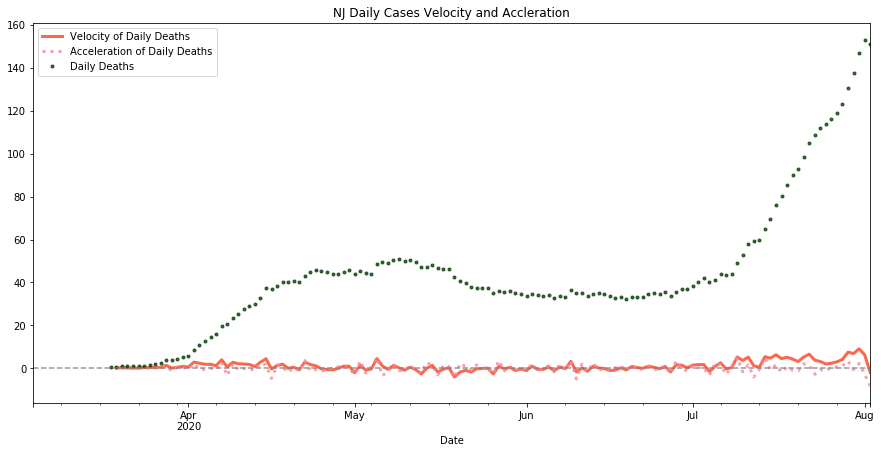

In [77]:
nj[['Velocity of Daily Deaths', 'Acceleration of Daily Deaths','Daily Deaths']].\
    rolling(window=14, min_periods=7).mean()[::-1].\
    plot(figsize=(15,7),
        title = 'NJ Daily Cases Velocity and Accleration',
        style=['-',':', '.'],
        linewidth = 3,
        kind='line',
        color = ['xkcd:orange red', 'xkcd:rose pink', 'xkcd:hunter green'],
        alpha = 0.8
        ).axhline(0,
                  color='gray',
                  linestyle='--',
                  alpha=0.8)

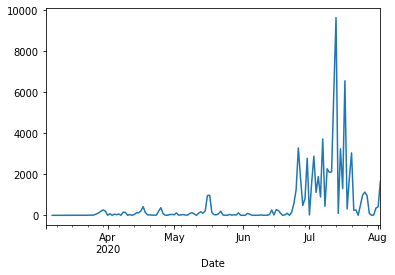

In [78]:
nj['Squared Accleration'].plot()

In [54]:
nj[['7 Day Rolling','14 Day Rolling', 'Doubling Time','Growth Factor']].tail()

,7 Day Rolling,14 Day Rolling,Doubling Time,Growth Factor
Date,,,,
2020-07-27,407.000000,306.428571,306.577846,0.889109
2020-07-28,434.142857,312.857143,288.203228,1.075724
2020-07-29,445.857143,320.571429,281.372417,0.975155
2020-07-30,440.428571,319.214286,285.157305,0.433121
2020-07-31,473.571429,364.928571,266.234754,3.382353


Text(0, 0.5, 'Days')

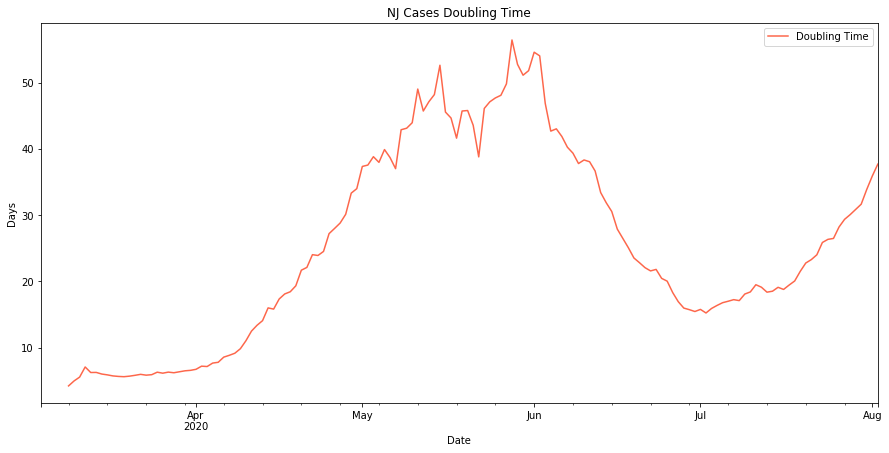

In [81]:
nj[['Doubling Time']].plot(figsize=(15,7),
        title = 'NJ Cases Doubling Time',
        style=['-'],
        linewidth = 1.5,
        kind='line',
        color = ['xkcd:orange red'],
        alpha = 0.8
        ).set_ylabel('Days')

In [68]:
for state in states:
    state_plots(state, get_state_data(state))

alabama returned 149 rows
alaska returned 150 rows
arizona returned 152 rows
arkansas returned 150 rows
california returned 152 rows
colorado returned 151 rows
connecticut returned 149 rows
delaware returned 150 rows
florida returned 152 rows
georgia returned 152 rows
hawaii returned 149 rows
idaho returned 149 rows
illinois returned 152 rows
indiana returned 150 rows
iowa returned 150 rows
kansas returned 150 rows
kentucky returned 150 rows
louisiana returned 149 rows
maine returned 149 rows
maryland returned 151 rows
massachusetts returned 144 rows
michigan returned 155 rows
minnesota returned 150 rows
mississippi returned 149 rows
missouri returned 149 rows
montana returned 149 rows
nebraska returned 151 rows
nevada returned 151 rows
new-hampshire returned 152 rows
new-jersey returned 151 rows
new-mexico returned 150 rows
new-york returned 152 rows
north-carolina returned 152 rows
north-dakota returned 149 rows
ohio returned 151 rows
oklahoma returned 149 rows
oregon returned 152 ro

In [83]:
print(get_url(dt.date(2020,5,15),'south'))

https://www.nj.com/coronavirus/2020/05/town-by-town-coronavirus-cases-and-deaths-in-south-jersey-may-15-2020.html


In [2]:
def upload_file(file_name, bucket, object_name=None, ExtraArgs={'ACL': 'public-read'}):
    """Upload a file to an S3 bucket

    :param file_name: File to upload
    :param bucket: Bucket to upload to
    :param object_name: S3 object name. If not specified then file_name is used
    :return: True if file was uploaded, else False
    """

    # If S3 object_name was not specified, use file_name
    if object_name is None:
        object_name = file_name

    # Upload the file
    s3_client = boto3.client('s3')
    try:
        response = s3_client.upload_file(file_name, bucket, object_name)
    except ClientError as e:
        logging.error(e)
        return False
    print(f'{object_name} added to {bucket}.')
    return True

DAYS = dt.date.today() - dt.date(2020,3,25)
NOW = dt.date.today()
YESTERDAY = dt.date.today() + dt.timedelta(days = -DAYS.days)
MONTHDAYYEAR = "%m-%d-%Y"
days_with_data = []

county = re.compile(r'^\s?(\w*[\s\w]*)\sCOUNTY.*\((?:state reports?\s?)?(\d+\,\d+|\d+)\s(?:cases?|with).*')
town = re.compile(r'.[\*\s]?([\w\s]*):\s(\d+\,\d+|\d+).*')
deaths = re.compile(
            r'.*\w*:\s?.*(?:with)?\s(\d+\,\d+|\d+)\s(?:death|fatalitie|fatality|who died)s?.*',
            re.IGNORECASE
        )
recovered = re.compile(
            r'.*(\d+\,\d+|\d+)\s(?:cleared from quarantine|who recovered'\
            +r'|have recovered|recovered).*',
            re.IGNORECASE
            )

hdr = {'User-Agent': 'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36' +\
           '(KHTML, like Gecko) Chrome/51.0.2704.103 Safari/537.36' }

towns = []
counties = []


def get_url(day, region='north'):
    if day < dt.date(2020,5,11):
        return f"https://www.nj.com/coronavirus/{day.strftime('%Y')}/{day.strftime('%m')}/"+\
                f"where-is-the-coronavirus-in-nj-latest-map-update-on-county-by-county-cases-"+\
                f"{day.strftime('%B').lower()}-{day.strftime('%-d')}-{day.strftime('%Y')}.html"
    return f"https://www.nj.com/coronavirus/{day.strftime('%Y')}/{day.strftime('%m')}/"+\
                f"town-by-town-coronavirus-cases-and-deaths-in-{region.lower()}-jersey-"+\
                f"{day.strftime('%B').lower()}-{day.strftime('%-d')}-{day.strftime('%Y')}.html"


def open_url(day, hdr, fix_html = False, regex = r'<div class="rawhtml".*\(\);'):
    url = get_url(day)
    if fix_html:
        try:
            req = request.Request(url, headers=hdr)
            html = bs(request.urlopen(url), 'lxml')
            print(f'Date: {day.strftime(MONTHDAYYEAR)} Successfully opened and repaired')
        except HTTPError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
        except URLError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
    else:
        try:
            req = request.Request(url, headers=hdr)
            response = request.urlopen(req)

            html = bs(re.sub(
                        regex,
                        '',
                        response.read().decode('utf-8')),
                      'lxml'
                      )
            print(f'Date: {day.strftime(MONTHDAYYEAR)} Successfully opened')
        except HTTPError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
        except URLError as e:
            print(f'Date: {day.strftime(MONTHDAYYEAR)}\nError trying to open {url}\n{e}')
            return None
    days_with_data.append(1)
    return html


def scraper(day, hdr, fix_html):
    current_html = open_url(day, hdr, fix_html)
    if not current_html:
        return False
    
    current_county = ''
    max_county_cases = 0
    
    for p in current_html.find_all('p', ['article__paragraph', 'article__paragraph--left']):
        county_match = county.match(p.text)
        if county_match:
            current_county = county_match.group(1).title()
            current_cases = int(county_match.group(2).replace(',', ''))
            if current_cases > 20000 or True in [len(n) != 3 for n in county_match.group(2).split(',')[1:]]:
                current_cases = np.nan
            counties.append(
                [day.strftime(MONTHDAYYEAR),
                 current_county,
                 current_cases]
                )
            if current_cases > max_county_cases:
                max_county_cases = current_cases
        
        if town.match(p.text):
            town_match = town.match(p.text)
            town_name = town_match.group(1)
            town_ct = int(town_match.group(2).replace(',', ''))
            death_ct = 0
            recovered_ct = 0
            
            if town_ct > max_county_cases or True in [len(n) != 3 for n in town_match.group(2).split(',')[1:]]:
                town_ct = np.nan
            
            if deaths.match(p.text):
                death_ct = int(deaths.match(p.text).group(1).replace(',', ''))
            if recovered.match(p.text):
                recovered_ct = int(recovered.match(p.text).group(1).replace(',', ''))
            towns.append(
                        [day.strftime(MONTHDAYYEAR),
                         current_county,
                         town_name,
                         town_ct,
                         death_ct,
                         recovered_ct
                        ])
        
for delta in range(DAYS.days, -1, -1):
    current_day = NOW + dt.timedelta(days=-delta)
    if current_day in [dt.date(2020,3,27), dt.date(2020,3,28), dt.date(2020,4,18)]:
        fix_html = True
    else:
        fix_html = False
    scraper(current_day, hdr, fix_html)
    
towns = pd.DataFrame(towns,
                     columns=['Date','County', 'City', 'Cases',
                              'Deaths', 'Recoveries']
                    )

counties = pd.DataFrame(counties,
                      columns=['Date', 'County', 'Cases'])

towns.Date = pd.to_datetime(towns.Date)
counties.Date = pd.to_datetime(counties.Date)

print('\nTowns data points: ', towns.shape[0])
print('\nCounties data points: ', counties.shape[0])

Date: 03-25-2020 Successfully opened
Date: 03-26-2020 Successfully opened
Date: 03-27-2020 Successfully opened and repaired
Date: 03-28-2020 Successfully opened and repaired
Date: 03-29-2020 Successfully opened
Date: 03-30-2020 Successfully opened
Date: 03-31-2020 Successfully opened
Date: 04-01-2020 Successfully opened
Date: 04-02-2020 Successfully opened
Date: 04-03-2020 Successfully opened
Date: 04-04-2020 Successfully opened
Date: 04-05-2020 Successfully opened
Date: 04-06-2020 Successfully opened
Date: 04-07-2020 Successfully opened
Date: 04-08-2020 Successfully opened
Date: 04-09-2020 Successfully opened
Date: 04-10-2020 Successfully opened
Date: 04-11-2020 Successfully opened
Date: 04-12-2020 Successfully opened
Date: 04-13-2020 Successfully opened
Date: 04-14-2020 Successfully opened
Date: 04-15-2020 Successfully opened
Date: 04-16-2020 Successfully opened
Date: 04-17-2020 Successfully opened
Date: 04-18-2020 Successfully opened and repaired
Date: 04-19-2020 Successfully opened

In [3]:
counties.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 853 entries, 0 to 852
Data columns (total 3 columns):
Date      853 non-null datetime64[ns]
County    853 non-null object
Cases     850 non-null float64
dtypes: datetime64[ns](1), float64(1), object(1)
memory usage: 20.1+ KB


In [4]:
counties.County.unique()

array(['Atlantic', 'Bergen', 'Burlington', 'Camden', 'Cape May',
       'Cumberland', 'Essex', 'Gloucester', 'Hudson', 'Hunterdon',
       'Mercer', 'Middlesex', 'Monmouth', 'Morris', 'Ocean', 'Passaic',
       'Salem', 'Somerset', 'Sussex', 'Union', 'Warren'], dtype=object)

In [5]:
counties[['County','Date']].groupby('County').count() / sum(days_with_data)

,Date
County,
Atlantic,0.533333
Bergen,0.933333
Burlington,0.911111
Camden,0.911111
Cape May,0.933333
Cumberland,0.933333
Essex,0.933333
Gloucester,0.888889
Hudson,0.933333


In [6]:
counties[['County','Date']].groupby('Date').count() / 21

,County
Date,
2020-03-25,1.000000
2020-03-26,1.000000
2020-03-27,0.904762
2020-03-28,0.619048
2020-03-29,0.523810
2020-03-30,0.857143
2020-03-31,0.857143
2020-04-01,1.000000
2020-04-02,1.000000


In [7]:
counties[counties.Cases.isna()]

,Date,County,Cases
202,2020-04-05,Bergen,NaN
763,2020-05-04,Ocean,NaN
768,2020-05-04,Union,NaN


In [8]:
towns[towns.Cases.isna()]

,Date,County,City,Cases,Deaths,Recoveries
3756,2020-04-05,Bergen,Allendale,NaN,0,0
3757,2020-04-05,Bergen,Alpine,NaN,0,0
3758,2020-04-05,Bergen,Bergenfield,NaN,0,0
3759,2020-04-05,Bergen,Bogota,NaN,0,0
3760,2020-04-05,Bergen,Carlstadt,NaN,0,0
...,...,...,...,...,...,...
18542,2020-05-04,Union,Elizabeth,NaN,221,0
19079,2020-05-05,Union,Elizabeth,NaN,221,0
19621,2020-05-06,Union,Linden,NaN,58,3
19899,2020-05-07,Hudson,North Bergen,NaN,0,0


In [9]:
for county in counties.County.unique():
    counties.loc[counties.County == county,'Daily Difference'] =\
        counties[counties.County == county].Cases.diff()
    counties.loc[counties.County == county,'Acceleration'] =\
        counties[counties.County == county]['Daily Difference'].diff()

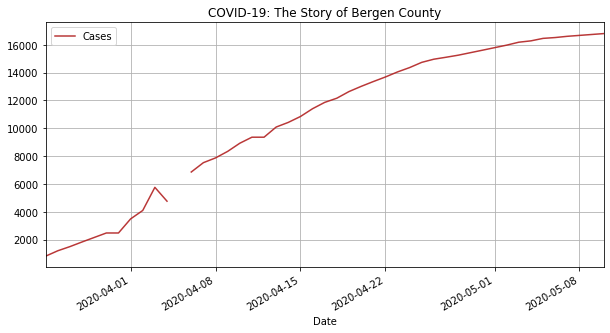

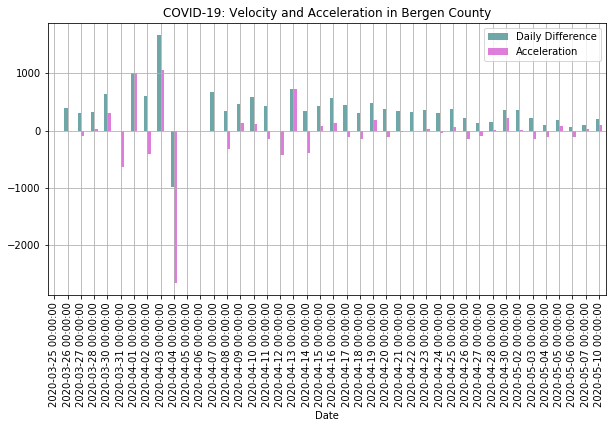

In [16]:
counties[counties.County == 'Bergen'].plot(x='Date',
                                           y='Cases',
                                           title='COVID-19: The Story of Bergen County',
                                           figsize=(10,5),
                                           grid=True,
                                           color = 'firebrick',
                                           alpha=0.9)
counties[counties.County == 'Bergen'].plot(x='Date',
                                           y=['Daily Difference','Acceleration'],
                                           title='COVID-19: Velocity and Acceleration in Bergen County',
                                           figsize=(10,5),
                                           grid = True,
                                           kind='bar',
                                           color = ['cadetblue','orchid'],
                                           alpha=0.9)

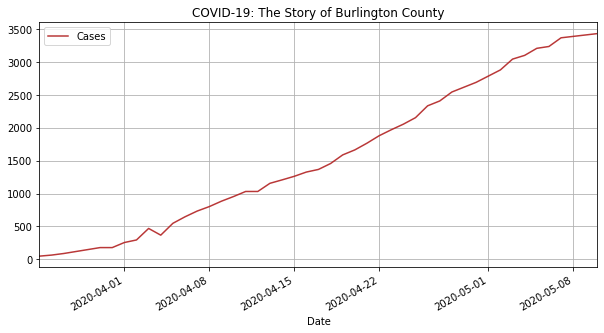

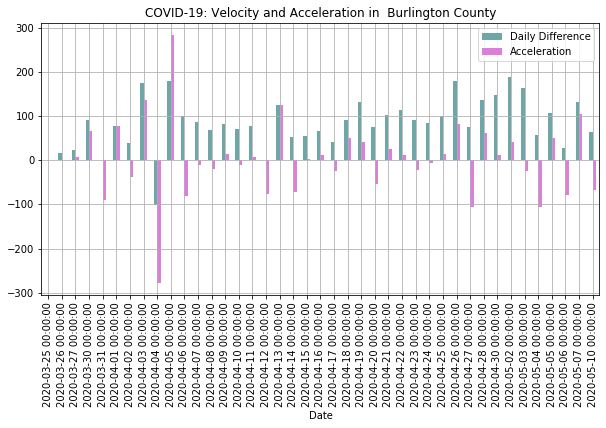

In [17]:
counties[counties.County == 'Burlington'].plot(x='Date',
                                           y='Cases',
                                           title='COVID-19: The Story of Burlington County',
                                           figsize=(10,5),
                                           grid=True,
                                           color = 'firebrick',
                                           alpha=0.9)
counties[counties.County == 'Burlington'].plot(x='Date',
                                           y=['Daily Difference','Acceleration'],
                                           title='COVID-19: Velocity and Acceleration in  Burlington County',
                                           figsize=(10,5),
                                           grid = True,
                                           kind = 'bar',
                                           color = ['cadetblue','orchid'],
                                           alpha=0.9
                                           ) 


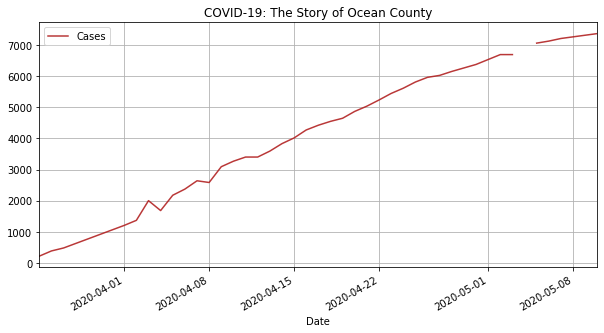

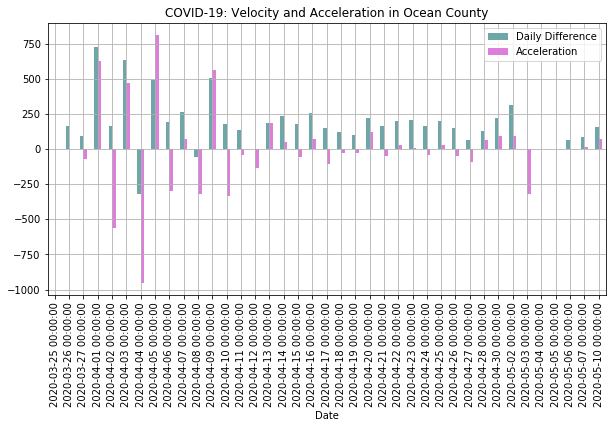

In [18]:
counties[counties.County == 'Ocean'].plot(x='Date',
                                           y='Cases',
                                           title='COVID-19: The Story of Ocean County',
                                           figsize=(10,5),
                                           grid=True,
                                           color = 'firebrick',
                                           alpha=0.9)
counties[counties.County == 'Ocean'].plot(x='Date',
                                           y=['Daily Difference','Acceleration'],
                                           title='COVID-19: Velocity and Acceleration in Ocean County',
                                           figsize=(10,5),
                                           grid = True,
                                           kind = 'bar',
                                           color = ['cadetblue','orchid'],
                                           alpha=0.9
                                           ) 


In [16]:
georgia = pd.read_html('https://covidtracking.com/data/state/georgia#historical')[1][::-1]
georgia.drop(['Screenshots (ET)', 'Pending'], axis=1, inplace = True)


georgia['Daily Positive'] = georgia['Cases'].diff(1)
georgia['Percent Positive'] = georgia['Daily Positive'] / georgia ['New Tests'] * 100.0
georgia['Daily Hospitalized'] = georgia.Hospitalized.diff(1)
georgia['Daily Deaths'] = georgia.Deaths.diff(1)
georgia['7 Day Rolling'] = georgia['Daily Positive'].rolling(window=7).mean()
georgia['14 Day Rolling'] = georgia['Daily Positive'].rolling(window=14).mean()
georgia['7 Day Rolling Percent Pos'] = georgia['Percent Positive'].rolling(window=7).mean()
georgia['Doubling Time'] = np.log(2) / np.log(1 + (georgia.Cases * georgia['Percent Positive'].rolling(window=7).sum()/7))
georgia.Date = pd.to_datetime(georgia.Date)
georgia.set_index('Date', inplace=True)

georgia.tail()

,New Tests,Cases,Negative,Hospitalized,Deaths,Total,Daily Positive,Percent Positive,Daily Hospitalized,Daily Deaths,7 Day Rolling,14 Day Rolling,7 Day Rolling Percent Pos,Doubling Time
Date,,,,,,,,,,,,,,
2020-06-10,13772,53980,516975.0,8974.0,2329.0,570955,731.0,5.307871,102.0,44.0,726.571429,682.785714,6.146916,0.054526
2020-06-11,13286,54973,529268.0,9073.0,2375.0,584241,993.0,7.474033,99.0,46.0,732.285714,707.357143,6.214981,0.054400
2020-06-12,7717,55783,536175.0,9181.0,2418.0,591958,810.0,10.496307,108.0,43.0,737.428571,722.357143,6.749354,0.053989
2020-06-13,7722,56801,542879.0,9224.0,2446.0,599680,1018.0,13.183113,43.0,28.0,784.571429,751.071429,7.980418,0.053220
2020-06-14,21110,57681,563109.0,9248.0,2451.0,620790,880.0,4.168640,24.0,5.0,826.142857,763.928571,8.081765,0.053105


Text(2020-03-09 00:00:00, 1, 'Under 5%')

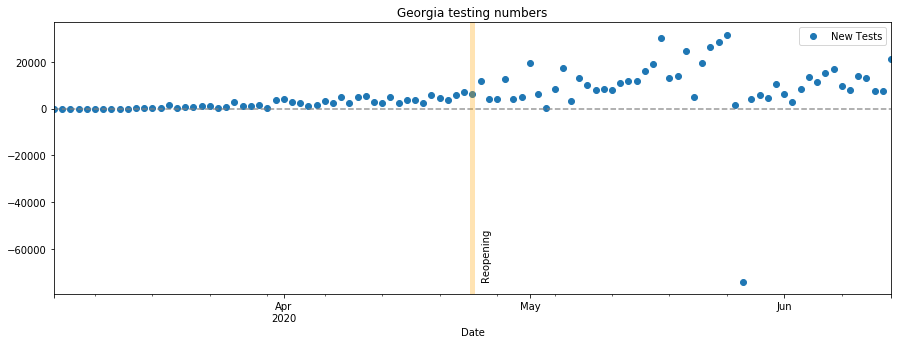

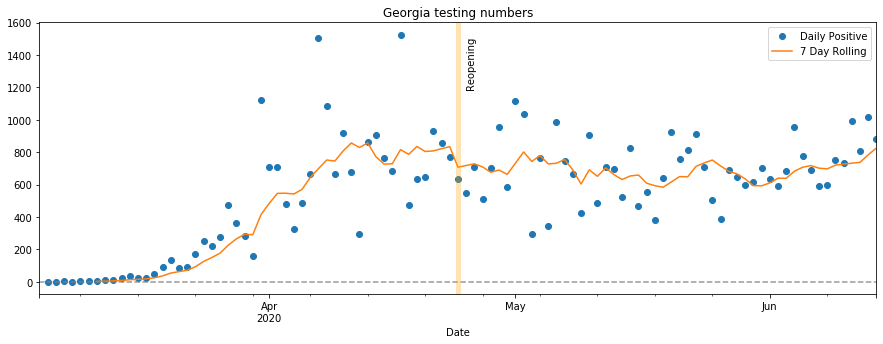

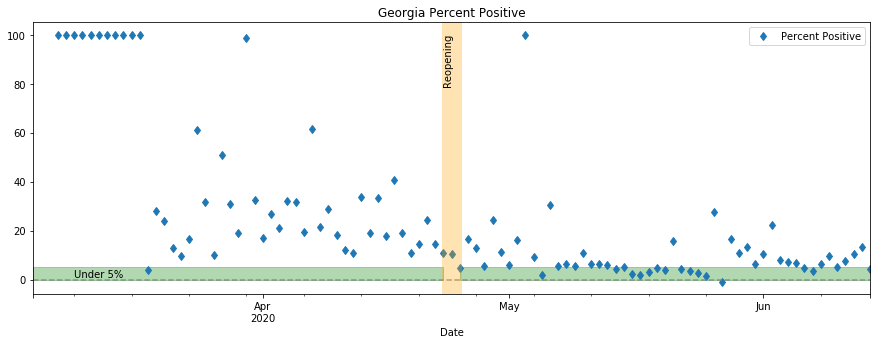

In [17]:
plot1 = georgia[['New Tests']].plot(style='o', figsize=(15,5), title='Georgia testing numbers')
plot1.axhline(0, color='gray', linestyle='--', alpha=0.8)
plot1.axvline(pd.Timestamp('2020-04-24'), color='orange', alpha=0.3, linewidth=5)
plot1.text(pd.Timestamp('2020-04-25'),georgia['New Tests'].min() + 1000,'Reopening',rotation=90)

plot1b = georgia[['Daily Positive','7 Day Rolling']].plot(style=['o','-'], figsize=(15,5), title='Georgia testing numbers')
plot1b.axhline(0, color='gray', linestyle='--', alpha=0.8)
plot1b.axvline(pd.Timestamp('2020-04-24'), color='orange', alpha=0.3, linewidth=5)
plot1b.text(pd.Timestamp('2020-04-25'),georgia['Daily Positive'].min() + 1200,'Reopening',rotation=90)

plot2 = georgia[['Percent Positive']].plot(style='d', figsize=(15,5), title='Georgia Percent Positive')
plot2.axhline(0, color='gray', linestyle='--', alpha=0.8)
plot2.fill_between(georgia.index,0,5, color='green', alpha=0.3, where=georgia.index!=pd.Timestamp('2020-04-24'))
plot2.axvline(pd.Timestamp('2020-04-24'), color='orange', alpha=0.3, linewidth=20)
plot2.text(pd.Timestamp('2020-04-23'),80,'Reopening',rotation=90)
plot2.text(pd.Timestamp('2020-03-09'),1,'Under 5%')

In [5]:
newjersey = pd.read_html('https://covidtracking.com/data/state/new-jersey#historical')[1][::-1]
newjersey.drop(['Screenshots (ET)', 'Pending'], axis=1, inplace = True)
newjersey.Date = pd.to_datetime(newjersey.Date)
newjersey.set_index('Date', inplace=True)
newjersey['Daily Positive'] = newjersey['Cases'].diff(1)
newjersey['Percent Positive'] = newjersey['Daily Positive'] / newjersey ['New Tests'] * 100.0
newjersey['Daily Hospitalized'] = newjersey.Hospitalized.diff(-1)
newjersey['Daily Deaths'] = newjersey.Deaths.diff(-1)
newjersey['7 Day Rolling'] = newjersey['Daily Positive'].rolling(window=7).mean()
newjersey['14 Day Rolling'] = newjersey['Daily Positive'].rolling(window=14).mean()
newjersey['7 Day Rolling Percent Pos'] = newjersey['Percent Positive'].rolling(window=7).mean()
newjersey['Doubling Time'] = np.log(2) / np.log(1 + (newjersey.Cases * newjersey['Percent Positive'].rolling(window=7).sum()/7))

newjersey.tail()

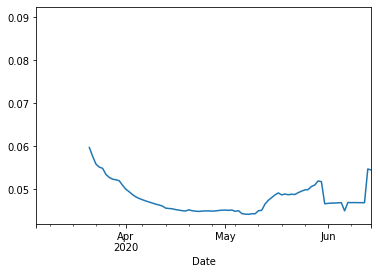

In [8]:
newjersey['Doubling Time'].plot()

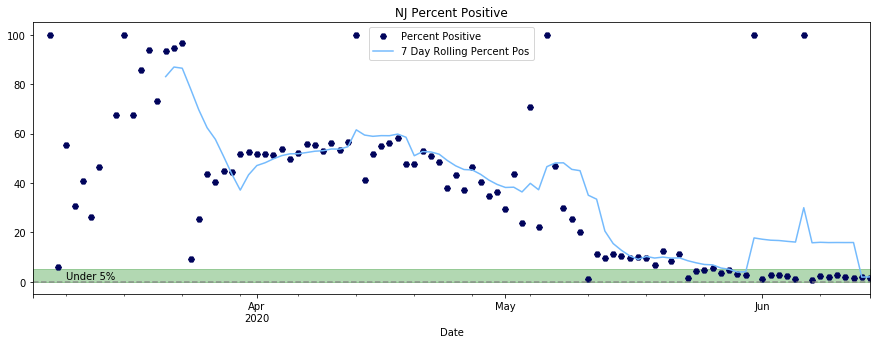

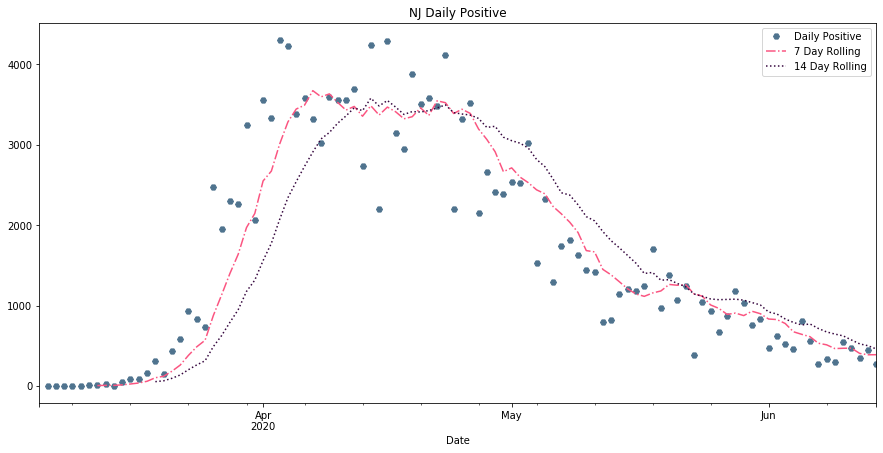

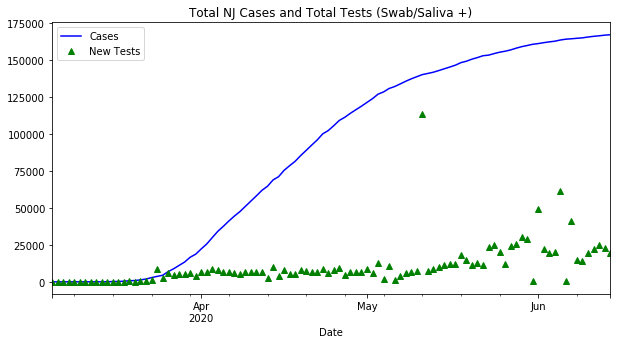

In [11]:
plot3 = newjersey[['Percent Positive','7 Day Rolling Percent Pos']].\
    plot(style=['H','-'],
         color=['xkcd:dark blue','xkcd:sky blue'],
         figsize=(15,5),
         title='NJ Percent Positive')
plot3.axhline(0, color='gray', linestyle='--', alpha=0.8)
plot3.fill_between(newjersey.index,0,5, color='green', alpha=0.3)
#plot3.axvline(pd.Timestamp('2020-04-24'), color='orange', alpha=0.3, linewidth=20)
#plot3.text(pd.Timestamp('2020-04-23'),80,'Reopening',rotation=90)
plot3.text(pd.Timestamp('2020-03-09'),1,'Under 5%')

plot4 = newjersey[['Daily Positive','7 Day Rolling','14 Day Rolling']].\
    plot(style=['H','-.',':'],
         color=['xkcd:metallic blue','xkcd:warm pink','xkcd:dark purple'],
         figsize=(15,7),
         title='NJ Daily Positive').set_facecolor('white')

plot4 = newjersey[['Cases','New Tests']].plot(
    style=['-','^'],color=['blue','green'],figsize=(10,5), title='Total NJ Cases and Total Tests (Swab/Saliva +)')

In [14]:
newjersey['7 Day Rolling'][-7:]

Date
2020-05-26    964.428571
2020-05-27    889.857143
2020-05-28    906.142857
2020-05-29    875.000000
2020-05-30    929.142857
2020-05-31    898.714286
2020-06-01    832.285714
Name: 7 Day Rolling, dtype: float64

In [15]:
georgia['Percent Positive'][7::-1].describe()

count     8.000000
mean     10.747597
std       8.973135
min      -0.931405
25%       5.312941
50%      10.508571
75%      14.287001
max      27.571429
Name: Percent Positive, dtype: float64

In [16]:
newjersey['Percent Positive'][7::-1].describe()

count      6.000000
mean      43.230240
std       32.282681
min        6.060606
25%       27.257525
50%       35.839161
75%       51.893939
max      100.000000
Name: Percent Positive, dtype: float64

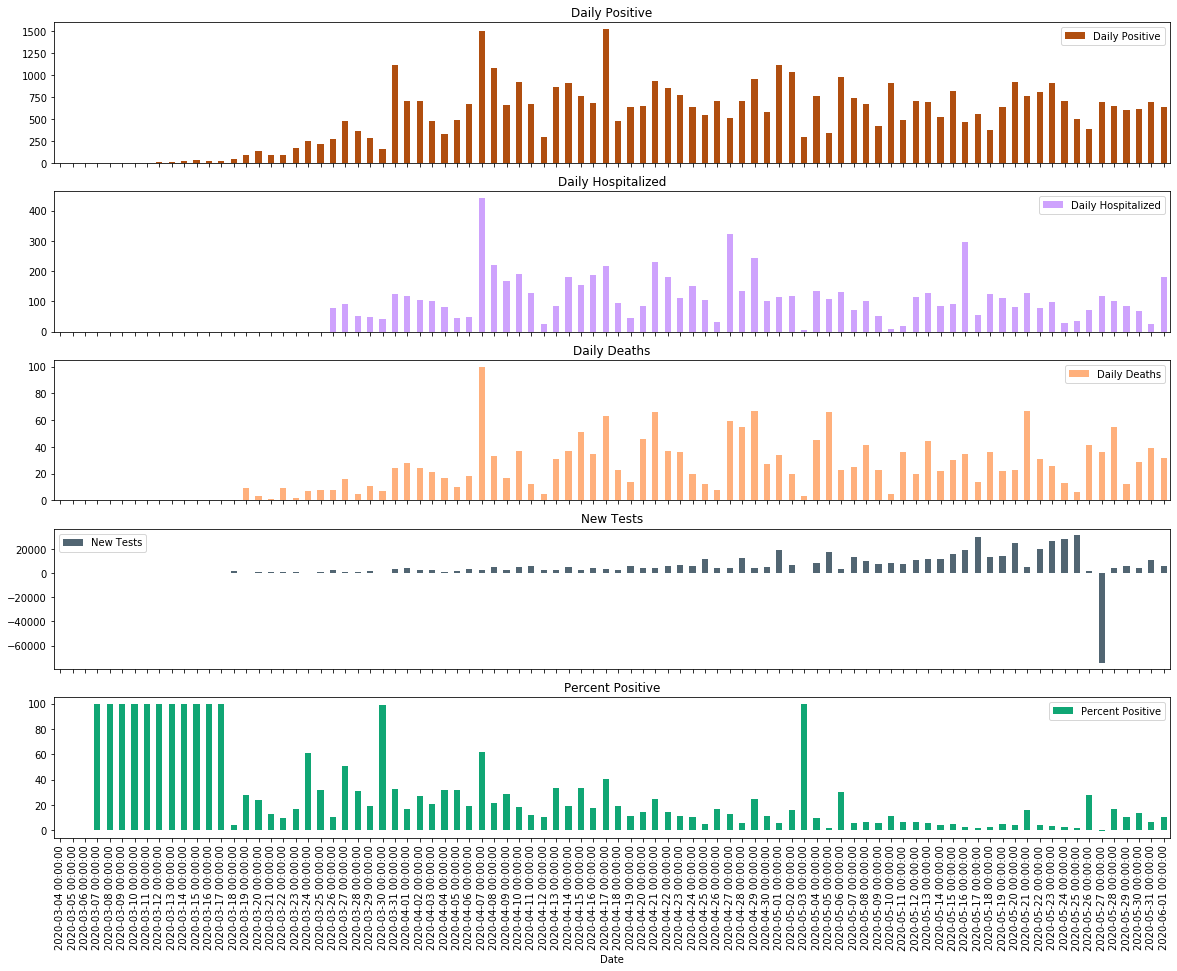

In [17]:
ax = georgia[
    ['Daily Positive','Daily Hospitalized', 'Daily Deaths',
     'New Tests', 'Percent Positive']
        ][::-1].plot(figsize=(20,15),
                     color = ['xkcd:burnt sienna', 'xkcd:lilac', 'xkcd:peach',
                             'xkcd:slate', 'xkcd:bluish green'],
                     kind = 'bar',
                     subplots=True,
                     )